In [1]:
import xarray as xr
import numpy as np
import xoak
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from tqdm import tqdm
#import parcels

In [31]:
### to do
def interp_fesom(
    mesh_file = None, 
    u_file =  None,
    v_file = None,
    w_file = None,
    nlon = None,
    nlat = None,
    
):
    return u_interp, v_interp, w_interp

for year in range(1957, 2050,1):
    u_interp, v_interp, w_interp =  interp_fesom()
    
    u_interp.drop_encoding().to_netcdf(f'/gxfs_work/geomar/smomw662/FESOM_data/channel_interp/u.{year}.nc') 
    v_interp.drop_encoding().to_netcdf()
    w_interp.drop_encoding().to_netcdf()

In [2]:
#%------------- Set the paths
path1 = "../../FESOM_data/channel/"
mesh_fn = "fesom.mesh.diag.nc"
u_path = 'u.fesom.2005.nc'
v_path = 'v.fesom.2005.nc'
w_path = 'w.fesom.2005.nc'
out_path = '/gxfs_work/geomar/smomw662/FESOMparcels_first/data/' #path to store the particle zarr
out_fn = 'UVW2_FESOM_track'

#%------------- Particles
## Set the number of particles
num_particles = 1

## Set the location of the particles 
lon_start = np.random.uniform(2,3,size=(num_particles,)) 
lat_start = np.random.uniform(7.5, 12.5, size=(num_particles,))

## set the tracking time
days = 400
minutes = 20

## record the particles every timestep of
hours=4

In [3]:
ds_mesh = xr.open_dataset(path1+mesh_fn)
#now we define new coords
ds_mesh = ds_mesh.assign_coords(
    nod2=list(range(1, ds_mesh.sizes["nod2"]+1)), 
    elem=list(range(1,ds_mesh.sizes['elem']+1)),
)

#corners
elem_corner_lons = ds_mesh.lon.sel(nod2=ds_mesh.face_nodes)
elem_corner_lats = ds_mesh.lat.sel(nod2=ds_mesh.face_nodes)

max_elem_lon_range = 0.2
tri_overlap=(elem_corner_lons.max('n3') - elem_corner_lons.min('n3')) > max_elem_lon_range

near_channel_width =4
channel_width = 4.5
elem_corner_lons_unglued = xr.where(tri_overlap & (elem_corner_lons > near_channel_width), 
                                   elem_corner_lons - channel_width, elem_corner_lons)


elem_center_lons_unglued = elem_corner_lons_unglued.mean('n3')
elem_center_lats = elem_corner_lats.mean('n3')

elem_center_lons = elem_corner_lons.mean('n3')

## assign coordinates to the mesh
ds_mesh = ds_mesh.assign_coords(
    elem_center_lons=elem_center_lons_unglued,
    elem_center_lats=elem_center_lats,
)
#nearest neighbour interpolation
ds_mesh.xoak.set_index(['elem_center_lats','elem_center_lons'], 'sklearn_geo_balltree')

channel_lon_bds = (0,4.5) # use inmutable objects
channel_lat_bds = (0,18)
number_lon = 2*72 
number_lat = 2*292

# w_lon = number_lon
# w_lat = number_lat
# w_lon = int(2*51.5)
# w_lat = int(2*206)

grid_lon = xr.DataArray(np.linspace(*channel_lon_bds,number_lon), 
                        dims=('grid_lon',))
grid_lat = xr.DataArray(np.linspace(*channel_lat_bds,number_lat),
                        dims=('grid_lat',))

#reorder the lat and lon into a C grid
target_lon, target_lat = xr.broadcast(grid_lon, grid_lat)

#select the grid elements
grid_elems = ds_mesh.xoak.sel(
    elem_center_lats = target_lat,
    elem_center_lons = target_lon,
).elem

grid_elems = grid_elems.assign_coords(
    target_lat = target_lat,
    target_lon = target_lon,
)

grid_elems = grid_elems.assign_coords(
    grid_lat=grid_lat,
    grid_lon=grid_lon,
)

## modify the mesh for nodes and 
ds_mesh = ds_mesh.assign_coords(
    lat=("nod2", ds_mesh.lat.data.flatten()),
    lon=("nod2", ds_mesh.lon.data.flatten()),
)
#
# Ensure the xoak index 
ds_mesh.xoak.set_index(["lat", "lon"], "sklearn_geo_balltree")

#-------------get the nod2grids
#grid_nodes
grid_nodes = ds_mesh.xoak.sel(
    lat = target_lat,
    lon = target_lon,
).nod2

## Equal depth levels

In [4]:
za = ds_mesh.nz.values #41
zb = ds_mesh.nz1.values #40

zc = np.array(sorted(np.concatenate((za, zb))))
#print(zc)

zg = np.sort(np.hstack((0.5 * (zc[0:-1] + zc[1:]), zc)))

#nz grid 
nz_grid = ds_mesh.sel(nz = zg, method = 'nearest').nz
print(nz_grid.astype(int))

nz1_grid = ds_mesh.sel(nz1 = zg, method = 'nearest').nz1
print(nz1_grid.astype(int))

<xarray.DataArray 'nz' (nz: 161)> Size: 1kB
array([   0,    0,    9,    9,    9,    9,    9,   18,   18,   18,   18,
         29,   29,   29,   41,   41,   41,   41,   55,   55,   55,   55,
         69,   69,   69,   69,   85,   85,   85,   85,  103,  103,  103,
        103,  122,  122,  122,  122,  144,  144,  144,  144,  144,  167,
        167,  167,  193,  193,  193,  193,  221,  221,  221,  221,  252,
        252,  252,  252,  252,  287,  287,  287,  287,  324,  324,  324,
        324,  366,  366,  366,  412,  412,  412,  412,  462,  462,  462,
        462,  517,  517,  517,  517,  578,  578,  578,  578,  578,  645,
        645,  645,  718,  718,  718,  718,  799,  799,  799,  799,  888,
        888,  888,  888,  986,  986,  986,  986,  986, 1094, 1094, 1094,
       1212, 1212, 1212, 1212, 1343, 1343, 1343, 1343, 1486, 1486, 1486,
       1486, 1644, 1644, 1644, 1644, 1644, 1817, 1817, 1817, 2008, 2008,
       2008, 2008, 2008, 2218, 2218, 2218, 2449, 2449, 2449, 2449, 2703,
       

## Load the data U,V,W

In [5]:
%%time
ds_u = xr.open_dataset(path1+u_path).compute()
# first selecting only the surface nz1=0
ds_v = xr.open_dataset(path1+v_path).compute()

ds_w = xr.open_dataset(path1+w_path).compute()

CPU times: user 13.6 s, sys: 1.68 s, total: 15.3 s
Wall time: 15.7 s


In [6]:
ds_u.nbytes/1e6

1233.41124

In [7]:
# za = ds_mesh.nz.values #41
# zb = ds_mesh.nz1.values #40

z_target = xr.DataArray(
    sorted(list(ds_mesh.nz1.data) + list(ds_mesh.nz.data[[0,-1]])),
    dims = 'z',)
z_target

<xarray.DataArray (z: 42)> Size: 336B
array([   0.     ,    4.51883,   14.00838,   24.44685,   35.9292 ,
         48.5598 ,   62.4534 ,   77.7364 ,   94.5479 ,  113.0405 ,
        133.382  ,  155.7575 ,  180.371  ,  207.446  ,  237.228  ,
        269.9885 ,  306.025  ,  345.665  ,  389.2695 ,  437.234  ,
        489.995  ,  548.0325 ,  611.8735 ,  682.0985 ,  759.346  ,
        844.318  ,  937.787  , 1040.6035 , 1153.7    , 1278.11   ,
       1414.96   , 1565.49   , 1731.075  , 1913.22   , 2113.58   ,
       2333.98   , 2576.42   , 2843.095  , 3136.44   , 3459.125  ,
       3814.075  , 4000.     ])
Dimensions without coordinates: z

In [8]:
U_grid = ds_u.u.isel(elem=grid_elems - 1).sel(nz1=z_target,method = 'nearest') 
V_grid = ds_v.v.isel(elem=grid_elems - 1).sel(nz1=z_target,method = 'nearest') 
W_grid = ds_w.w.isel(nod2=grid_nodes - 1).sel(nz=z_target,method = 'nearest')

In [11]:
W_grid

<xarray.DataArray 'w' (time: 365, z: 42, grid_lon: 144, grid_lat: 584)> Size: 5GB
array([[[[-2.53971799e-09, -2.53971799e-09,  2.58052046e-09, ...,
           5.55793500e-09,  5.55793500e-09,  5.55793500e-09],
         [-2.53971799e-09, -2.53971799e-09,  2.58052046e-09, ...,
           5.55793500e-09,  5.55793500e-09,  5.55793500e-09],
         [-4.28638725e-09, -4.28638725e-09,  2.58052046e-09, ...,
           2.83838641e-09,  2.83838641e-09,  2.83838641e-09],
         ...,
         [-5.37354938e-10, -5.37354938e-10,  3.78119092e-09, ...,
           1.03223075e-08,  1.03223075e-08,  1.03223075e-08],
         [-5.37354938e-10,  3.78119092e-09,  3.78119092e-09, ...,
           1.03223075e-08,  1.03223075e-08,  1.03223075e-08],
         [-5.37354938e-10,  3.78119092e-09,  3.78119092e-09, ...,
           1.03223075e-08,  1.03223075e-08,  1.03223075e-08]],

        [[ 2.83567346e-07,  2.83567346e-07,  2.96876905e-08, ...,
           1.48794834e-06,  1.48794834e-06,  1.48794834e-06],
         [ 2.83567346e-07,  2.83567346e-07,  2.96876905e-08, ...,
           1.48794834e-06,  1.48794834e-06,  1.48794834e-06],
         [ 5.03912929e-07,  5.03912929e-07,  2.96876905e-08, ...,
          -9.92855078e-08, -9.92855078e-08, -9.92855078e-08],
...
           3.91763251e-06,  3.91763251e-06,  3.91763251e-06],
         [ 2.08010738e-06,  2.43646582e-06,  2.43646582e-06, ...,
           3.91763251e-06,  3.91763251e-06,  3.91763251e-06],
         [ 2.08010738e-06,  2.43646582e-06,  2.43646582e-06, ...,
           3.91763251e-06,  3.91763251e-06,  3.91763251e-06]],

        [[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00]]]],
      dtype=float32)
Coordinates:
    nz       (z) float64 336B 0.0 9.038 9.038 ... 3.628e+03 3.628e+03 4e+03
  * time     (time) datetime64[ns] 3kB 2005-01-01T23:50:00 ... 2005-12-31T23:...
    lon      (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0469 ... 4.406 4.406
    lat      (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0814 ... 17.9 17.9
    nod2     (grid_lon, grid_lat) int64 673kB 1 1 2 2 ... 10608 10608 10608
Dimensions without coordinates: z, grid_lon, grid_lat
Attributes:
    description:  vertical velocity
    long_name:    vertical velocity
    units:        m/s
    location:     node
    mesh:         fesom_mesh

In [27]:
W_grid=W_grid.assign_coords(
    grid_lon = target_lon.isel(grid_lat = 0, drop = True),
    grid_lat = target_lat.isel(grid_lon = 0, drop = True),
    z = z_target,
    )

U_grid=U_grid.assign_coords(
    grid_lon = target_lon.isel(grid_lat = 0, drop = True),
    grid_lat = target_lat.isel(grid_lon = 0, drop = True),
    z = z_target,
    )

V_grid=V_grid.assign_coords(
    grid_lon = target_lon.isel(grid_lat = 0, drop = True),
    grid_lat = target_lat.isel(grid_lon = 0, drop = True),
    z = z_target,
    )

In [28]:
V_grid

<xarray.DataArray 'v' (time: 365, z: 42, grid_lon: 144, grid_lat: 584)> Size: 5GB
array([[[[ 1.5995147e-04,  5.2130981e-03,  5.2130981e-03, ...,
          -7.0018094e-04, -7.0018094e-04, -7.0018094e-04],
         [ 1.5995147e-04,  1.5995147e-04,  5.2130981e-03, ...,
          -7.0018094e-04, -7.0018094e-04, -7.0018094e-04],
         [ 1.5995147e-04,  1.5995147e-04,  5.4869954e-03, ...,
          -7.0018094e-04, -7.0018094e-04, -7.0018094e-04],
         ...,
         [ 4.9367002e-03,  4.9367002e-03,  4.9367002e-03, ...,
           6.5161433e-04,  2.3442916e-04,  2.3442916e-04],
         [ 4.9367002e-03,  4.9367002e-03,  4.9367002e-03, ...,
           6.5161433e-04,  6.5161433e-04,  2.3442916e-04],
         [ 4.9367002e-03,  4.9367002e-03,  4.9367002e-03, ...,
           6.5161433e-04,  6.5161433e-04,  6.5161433e-04]],

        [[ 1.5995147e-04,  5.2130981e-03,  5.2130981e-03, ...,
          -7.0018094e-04, -7.0018094e-04, -7.0018094e-04],
         [ 1.5995147e-04,  1.5995147e-04,  5.2130981e-03, ...,
          -7.0018094e-04, -7.0018094e-04, -7.0018094e-04],
         [ 1.5995147e-04,  1.5995147e-04,  5.4869954e-03, ...,
          -7.0018094e-04, -7.0018094e-04, -7.0018094e-04],
...
           2.7937551e-03, -2.4453953e-05, -2.4453953e-05],
         [-6.2635094e-03, -6.2635094e-03, -6.2635094e-03, ...,
           2.7937551e-03,  2.7937551e-03, -2.4453953e-05],
         [-6.2635094e-03, -6.2635094e-03, -6.2635094e-03, ...,
           2.7937551e-03,  2.7937551e-03,  2.7937551e-03]],

        [[-2.1440894e-05, -6.1161309e-03, -6.1161309e-03, ...,
           8.0592057e-05,  8.0592057e-05,  8.0592057e-05],
         [-2.1440894e-05, -2.1440894e-05, -6.1161309e-03, ...,
           8.0592057e-05,  8.0592057e-05,  8.0592057e-05],
         [-2.1440894e-05, -2.1440894e-05, -5.8237715e-03, ...,
           8.0592057e-05,  8.0592057e-05,  8.0592057e-05],
         ...,
         [-6.2635094e-03, -6.2635094e-03, -6.2635094e-03, ...,
           2.7937551e-03, -2.4453953e-05, -2.4453953e-05],
         [-6.2635094e-03, -6.2635094e-03, -6.2635094e-03, ...,
           2.7937551e-03,  2.7937551e-03, -2.4453953e-05],
         [-6.2635094e-03, -6.2635094e-03, -6.2635094e-03, ...,
           2.7937551e-03,  2.7937551e-03,  2.7937551e-03]]]],
      dtype=float32)
Coordinates:
    nz1               (z) float64 336B 4.519 4.519 14.01 ... 3.814e+03 3.814e+03
  * time              (time) datetime64[ns] 3kB 2005-01-01T23:50:00 ... 2005-...
    elem              (grid_lon, grid_lat) int64 673kB 1 20682 ... 20680 20680
    elem_center_lons  (grid_lon, grid_lat) float64 673kB 0.0469 ... 4.406
    elem_center_lats  (grid_lon, grid_lat) float64 673kB 0.02713 ... 17.85
    target_lat        (grid_lon, grid_lat) float64 673kB 0.0 0.03087 ... 18.0
    target_lon        (grid_lon, grid_lat) float64 673kB 0.0 0.0 0.0 ... 4.5 4.5
  * grid_lon          (grid_lon) float64 1kB 0.0 0.03147 0.06294 ... 4.469 4.5
  * grid_lat          (grid_lat) float64 5kB 0.0 0.03087 0.06175 ... 17.97 18.0
  * z                 (z) float64 336B 0.0 4.519 14.01 ... 3.814e+03 4e+03
Attributes:
    description:  meridional velocity
    long_name:    meridional velocity
    units:        m/s
    location:     face
    mesh:         fesom_mesh

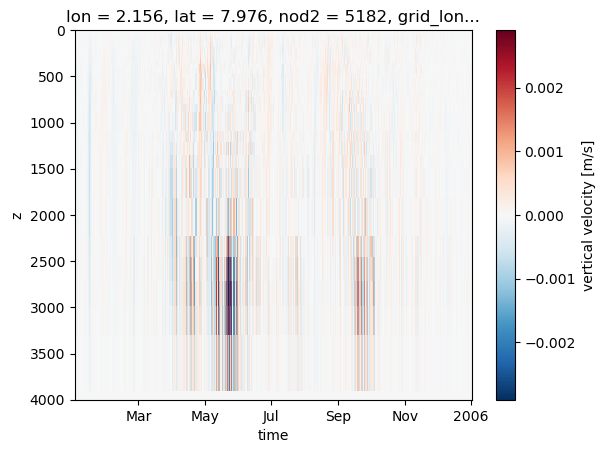

In [30]:
W_grid.sel(grid_lon = 2.2, grid_lat = 8, method = 'nearest').plot(x='time',y='z',ylim=(4000, 0))

In [10]:
U_grid.drop_encoding().to_netcdf('U_grid_interp.nc')

In [30]:
!du -sh U_grid_interp.zarr/

4.2G	U_grid_interp.zarr/


In [ ]:
print(U_grid.shape)
print(V_grid.shape)
print(W_grid.shape)

In [ ]:
ds_uv_grid= xr.Dataset({
    'U':U_grid,
    "V":V_grid,
    "W":W_grid,
})

In [ ]:
ds_uv_grid
## Keep only one Z and drop the other one

In [ ]:
ds_uv_grid = ds_uv_grid.drop_vars('nz1')

In [ ]:
ds_uv_grid['U'] = ds_uv_grid['U'].rename({'nz1':'nz'})
ds_uv_grid['V'] = ds_uv_grid['V'].rename({'nz1':'nz'})

In [ ]:
ds_uv_grid = ds_uv_grid.compute()

In [ ]:
#print(ds_uv_grid['U'].data.chunks)

## Now Parcels

In [ ]:
from parcels import ParticleSet
from parcels import JITParticle
from parcels import AdvectionRK4_3D
from parcels import AdvectionRK4
from datetime import timedelta
import numpy as np
from parcels import FieldSet

In [ ]:
fieldset = FieldSet.from_xarray_dataset(
    ds_uv_grid.transpose('time','nz','grid_lat','grid_lon'),
    variables={'U':"U", "V":"V", "W":"W"},
    dimensions={'lon':'grid_lon',
                'lat':'grid_lat',
                'depth':'nz',
                'time':'time',
               },
    time_periodic=False,
    allow_time_extrapolation=False,
)

In [ ]:
ds_uv_grid.nz

## Halo

In [ ]:
fieldset.add_constant("halo_west", fieldset.U.grid.lon[0])
fieldset.add_constant("halo_east", fieldset.U.grid.lon[-1])
fieldset.add_periodic_halo(zonal=True)

def periodicBC(particle,fielset,time):
    if particle.lon < fieldset.halo_west:
        particle_dlon += fieldset.halo_east - fieldset.halo_west
    elif particle.lon > fieldset.halo_east:
        particle_dlon -= fieldset.halo_east - fieldset.halo_west

In [ ]:
## Time and depth initial conditios
time = np.repeat(ds_uv_grid.time[0].data, num_particles)  # Assign the same time to all particles
depth = np.random.uniform(10,50, size=num_particles)  # Choose random depths
#time = np.repeat(ds_uv_grid.time[0], num_particles)  # Assign the same time to all particles


## Initiate particles

In [ ]:
#Init particle set
pset = ParticleSet(
    fieldset=fieldset,
    pclass=JITParticle,
    lon = lon_start,
    lat = lat_start,
    depth=depth,
    time=time
) 

# pset = parcels.ParticleSet.from_line(
#     fieldset=fieldset,
#     pclass=parcels.JITParticle,
#     size=10,
#     start=(1.9, 52.5),
#     finish=(3.4, 51.6),
#     depth=1,
# )

# lon = np.random.uniform(2, 3, size=num_particles)  # Longitudes between 2 and 3
# lat = np.random.uniform(7.5, 12.5, size=num_particles)  # Latitudes between 7.5 and 12.5
# depth = np.random.choice(ds_uv_grid.nz, size=num_particles)  # Choose random depths

# lon_start = np.random.uniform(2,3,size=(num_particles,)) 
# lat_start = np.random.uniform(7.5, 12.5, size=(num_particles,))


In [ ]:
output_file = pset.ParticleFile(name=out_path+out_fn, 
                                outputdt=timedelta(hours=hours))

In [ ]:
## Execute particles
pset.execute(
    [AdvectionRK4_3D,periodicBC],
    runtime=timedelta(days=days),
    dt=timedelta(minutes=minutes),
    output_file= output_file
)
## check out a different advection squeme

## Make a plot

In [33]:
import xarray as xr
import numpy as np
import xoak
from matplotlib import pyplot as plt
from cmocean import cm # for oceanography-specific colormaps
from itertools import zip_longest
from functools import reduce
from operator import add
from pathlib import Path
import tqdm

In [4]:
#out_path = '/gxfs_work/geomar/smomw662/FESOMparcels_first/data/' #path to store the particle zarr
#out_fn = 'UV_tracking_fesom'

In [32]:
ds_traj = xr.open_zarr(out_path+out_fn+".zarr")
ds_traj = ds_traj.compute()
ds_traj

<xarray.Dataset> Size: 74kB
Dimensions:     (trajectory: 10, obs: 364)
Coordinates:
  * obs         (obs) int32 1kB 0 1 2 3 4 5 6 7 ... 357 358 359 360 361 362 363
  * trajectory  (trajectory) int64 80B 0 1 2 3 4 5 6 7 8 9
Data variables:
    lat         (trajectory, obs) float32 15kB 12.42 12.37 12.33 ... 12.7 12.67
    lon         (trajectory, obs) float32 15kB 2.752 2.714 ... 0.8862 0.9196
    time        (trajectory, obs) datetime64[ns] 29kB 2006-01-01T23:50:00 ......
    z           (trajectory, obs) float32 15kB 25.29 25.25 25.21 ... 10.07 10.07
Attributes:
    Conventions:            CF-1.6/CF-1.7
    feature_type:           trajectory
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_kernels:        JITParticleAdvectionRK4_3DperiodicBC
    parcels_mesh:           spherical
    parcels_version:        3.0.5

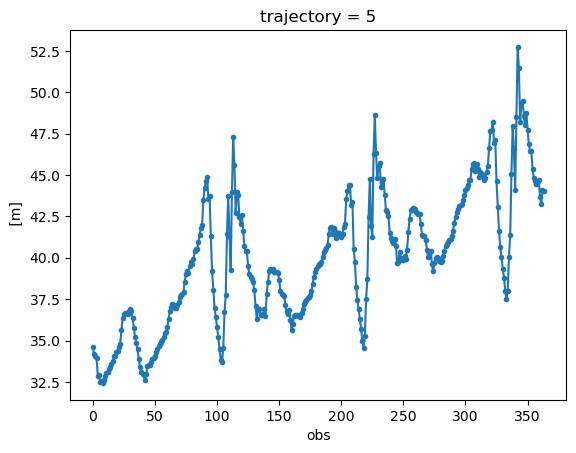

In [34]:
ds_traj.isel(trajectory=5).z.plot(marker='.')

<Axes: xlabel='lon'>

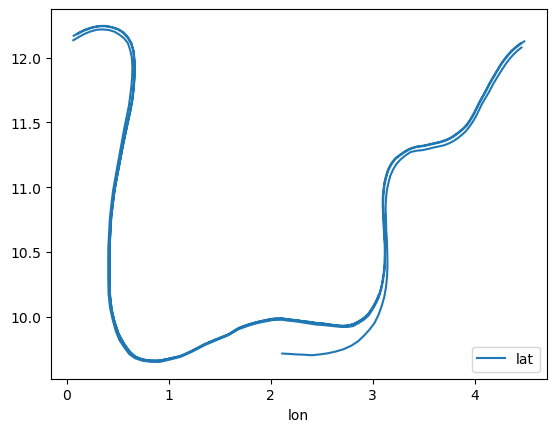

In [35]:
## Pre plot
skip_this_step = abs(ds_traj.lon.diff('obs')) > 4.0
ds_traj_nowrap = ds_traj.where(~skip_this_step)
ds_traj_nowrap.isel(trajectory=5).to_pandas().plot.line(
    x='lon', y='lat',
)

In [36]:
def line_between(start,end):
    """Find the intermediate points on a line from (x0,y0) to (x1,y1).

    Parameters
    ------------
    start: tuple
        Contains x0 and y0
    end: tuple
        Contains x1 and y1

    Returns
    --------
    list
        List of all intermediate points (x,y)

    """
    x0,y0 = start
    x1,y1 = end
    #This extracts the individual coordinates from the start and end tuples.
    N = max(abs(x1 - x0) + 1, abs(y1 - y0) + 1) #calculate the number of steps
    #Calculate the incremental step sizes
    dx = (x1 - x0) / (N - 1) #for stepping in lon or x
    dy = (y1 - y0) / (N - 1) #for stepping in lat or y
    #the steps secure the evenly spaced points between the start and end

    #Generate the intermediate points
    xx = (round(x0 + n * dx) for n in range(N))
    yy = (round(y0 + n * dy) for n in range(N))
    #Combines the x and y coordinates into a list of tuples 
    return list(zip(xx,yy))

def line_between_sequence(points):
    """ Fill in lines on all segments of points.

    Parameters
    ----------
    points: list
        List of points (x,y).

    Returns
    -------
    list
        List of points(x,y) with all segments filled in.

    """

    segments = [
    line_between(start,end)[:-1]
    for start, end in zip(points[:-1], points[1:])
    ] + [points[-1:], ]
    return reduce(add, segments)

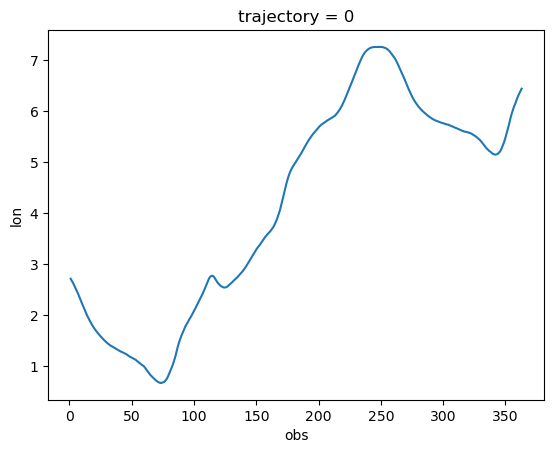

In [37]:
### Unrolling
ad_lon = 0 + 4.5 * (ds_traj.lon.diff('obs') < -4) - 4.5 * (ds_traj.lon.diff('obs') > 4)
lon_unrolled = (ds_traj.lon + ad_lon.cumsum('obs')) #we accumulate the corrections 
lon_unrolled.isel(trajectory=0).plot()

In [38]:
Nx = 45 #~4.5
Ny = 180 #~18.0

In [39]:
#Each ghost image band corresponds to an increment of 4.5 longitude units.
#Creates ghost images in left and right 
pix_replica_lon = lon_unrolled.min().compute().data[()] //4.5 , lon_unrolled.max().compute().data[()] //4.5 + 1
pix_x_unrolled = np.arange(pix_replica_lon[0] * Nx, pix_replica_lon[1] * Nx).astype(int)


In [61]:
lon_bds = (int(pix_replica_lon[0] *4.5), int(pix_replica_lon[1] * 4.5))
lat_bds = (0,18)
lon_bds_base = (0,4.5)
lon_bds, lat_bds


((0, 18), (0, 18))

In [51]:
dens = np.zeros((Ny,Nx), dtype=int)
## check the error of the tranpositn
for traj in tqdm.tqdm(ds_traj.trajectory.isel(trajectory=slice(None,None,1)).data):
    lon_traj = lon_unrolled.sel(trajectory=traj).compute().data
    lat_traj = ds_traj.lat.sel(trajectory=traj).compute().data
    point_list = list(zip(      
        np.digitize(lat_traj, np.linspace(*lat_bds, Ny)).astype(int) -1,
        np.digitize(lon_traj, np.linspace(*lon_bds, int((pix_replica_lon[1] - pix_replica_lon[0]) * Nx))).astype(int)-1,
    ))

    #drop the duplicates
    point_list = [i for i, j in zip_longest(point_list, point_list[1:]) if i !=j]
    pos,count = np.unique(np.array(line_between_sequence(point_list)), axis=0, return_counts = True)
    #wrap back to Nx and Ny
    pos = pos % [Ny,Nx]
    dens[*pos.T] +=count
    #break

100%|██████████████████████████████████████████████| 10/10 [00:00<00:00, 150.79it/s]


In [52]:
dens.shape

(180, 45)

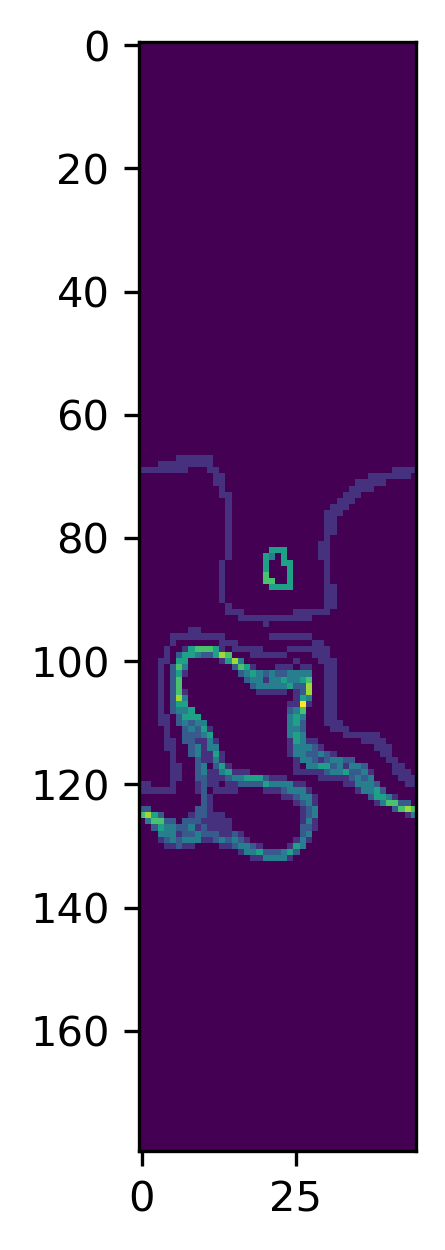

In [54]:
fig, ax = plt.subplots(1,1)
fig.set_dpi(300)
ax.imshow(dens)

In [62]:
dens_array = xr.DataArray(
    dens,
    dims = ('lat','lon'),
    coords = {
        'lat':np.linspace(*lat_bds, Ny), 
        'lon':np.linspace(*lon_bds_base, Nx), 
    },
)
dens_array             

<xarray.DataArray (lat: 180, lon: 45)> Size: 65kB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * lat      (lat) float64 1kB 0.0 0.1006 0.2011 0.3017 ... 17.7 17.8 17.9 18.0
  * lon      (lon) float64 360B 0.0 0.1023 0.2045 0.3068 ... 4.295 4.398 4.5

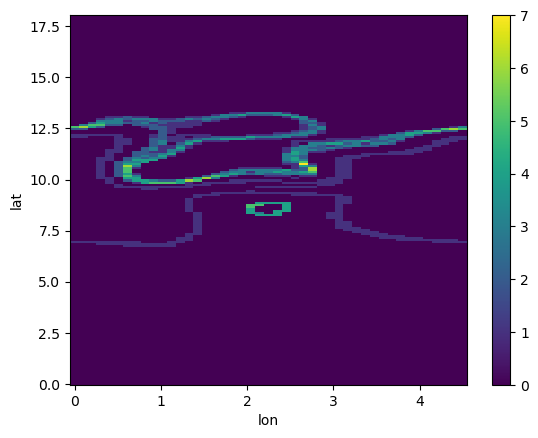

In [63]:
dens_array.plot.imshow()